# Replication for results in Davidson et al. 2017. "Automated Hate Speech Detection and the Problem of Offensive Language"

In [65]:
import pandas as pd
import numpy as np
import pickle
import sys
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem.porter import *
import string
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
from textstat.textstat import *
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

In [66]:
N_JOBS = 10

## Loading the data

In [67]:
df = pd.read_csv("../datasets/labeled_data.csv")

In [68]:
df

Unnamed: 0  count  hate_speech  offensive_language  neither  class  \
0               0      3            0                   0        3      2   
1               1      3            0                   3        0      1   
2               2      3            0                   3        0      1   
3               3      3            0                   2        1      1   
4               4      6            0                   6        0      1   
5               5      3            1                   2        0      1   
6               6      3            0                   3        0      1   
7               7      3            0                   3        0      1   
8               8      3            0                   3        0      1   
9               9      3            1                   2        0      1   
10             10      3            0                   3        0      1   
11             11      3            0                   3        0      1   
12             12      3            0                   2        1      1   
13             13      3            0                   3        0      1   
14             14      3            1                   2        0      1   
15             15      3            0                   3        0      1   
16             16      3            0                   3        0      1   
17             17      3            1                   2        0      1   
18             18      3            0                   3        0      1   
19             19      3            0                   3        0      1   
20             20      3            0                   3        0      1   
21             21      3            0                   3        0      1   
22             22      3            0                   3        0      1   
23             23      3            0                   3        0      1   
24             24      3            0                   3        0      1   
25             25      3            0                   2        1      1   
26             26      3            0                   3        0      1   
27             27      3            0                   3        0      1   
28             28      3            0                   3        0      1   
29             29      3            0                   3        0      1   
...           ...    ...          ...                 ...      ...    ...   
24753       25266      3            1                   2        0      1   
24754       25267      3            0                   3        0      1   
24755       25268      3            0                   3        0      1   
24756       25269      3            0                   3        0      1   
24757       25270      3            0                   3        0      1   
24758       25271      3            0                   3        0      1   
24759       25272      3            0                   3        0      1   
24760       25273      3            0                   2        1      1   
24761       25274      3            0                   3        0      1   
24762       25275      3            1                   2        0      1   
24763       25276      3            0                   2        1      1   
24764       25277      3            0                   3        0      1   
24765       25278      3            0                   3        0      1   
24766       25279      3            0                   3        0      1   
24767       25280      3            0                   1        2      2   
24768       25281      3            0                   3        0      1   
24769       25282      3            0                   3        0      1   
24770       25283      3            0                   3        0      1   
24771       25284      3            0                   3        0      1   
24772       25285      3            0                   3        0      1   
247

In [69]:
df.describe()

Unnamed: 0         count   hate_speech  offensive_language  \
count  24783.000000  24783.000000  24783.000000        24783.000000   
mean   12681.192027      3.243473      0.280515            2.413711   
std     7299.553863      0.883060      0.631851            1.399459   
min        0.000000      3.000000      0.000000            0.000000   
25%     6372.500000      3.000000      0.000000            2.000000   
50%    12703.000000      3.000000      0.000000            3.000000   
75%    18995.500000      3.000000      0.000000            3.000000   
max    25296.000000      9.000000      7.000000            9.000000   

            neither         class  
count  24783.000000  24783.000000  
mean       0.549247      1.110277  
std        1.113299      0.462089  
min        0.000000      0.000000  
25%        0.000000      1.000000  
50%        0.000000      1.000000  
75%        0.000000      1.000000  
max        9.000000      2.000000

In [70]:
df.columns

Index(['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither',
       'class', 'tweet'],
      dtype='object')

### Columns key:
count = number of CrowdFlower users who coded each tweet (min is 3, sometimes more users coded a tweet when judgments were determined to be unreliable by CF).


hate_speech = number of CF users who judged the tweet to be hate speech.


offensive_language = number of CF users who judged the tweet to be offensive.


neither = number of CF users who judged the tweet to be neither offensive nor non-offensive.


class = class label for majority of CF users.

    0 - hate speech
    1 - offensive  language
    2 - neither

tweet = raw tweet text


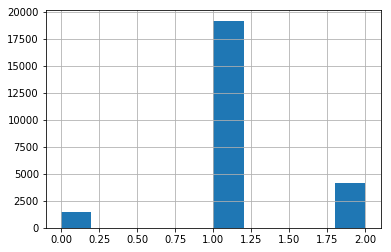

In [71]:
df['class'].hist()

This histogram shows the imbalanced nature of the task - most tweets containing "hate" words as defined by Hatebase were 
only considered to be offensive by the CF coders. More tweets were considered to be neither hate speech nor offensive language than were considered hate speech.

In [72]:
tweets=df.tweet

## Feature generation

In [73]:
stopwords=stopwords = nltk.corpus.stopwords.words("english")

other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)

stemmer = PorterStemmer()


def preprocess(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, '', parsed_text)
    parsed_text = re.sub(mention_regex, '', parsed_text)
    return parsed_text

def tokenize(tweet):
    """Removes punctuation & excess whitespace, sets to lowercase,
    and stems tweets. Returns a list of stemmed tokens."""
    tweet = " ".join(re.split("[^a-zA-Z]*", tweet.lower())).strip()
    tokens = [stemmer.stem(t) for t in tweet.split()]
    return tokens

def basic_tokenize(tweet):
    """Same as tokenize but without the stemming"""
    tweet = " ".join(re.split("[^a-zA-Z.,!?]*", tweet.lower())).strip()
    return tweet.split()

vectorizer = TfidfVectorizer(
    tokenizer=tokenize,
    preprocessor=preprocess,
    ngram_range=(1, 3),
    stop_words=stopwords,
    use_idf=True,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=10000,
    min_df=5,
    max_df=0.75
    )

In [74]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [75]:
#Construct tfidf matrix and get relevant scores
tfidf = vectorizer.fit_transform(tweets).toarray()
vocab = {v:i for i, v in enumerate(vectorizer.get_feature_names())}
idf_vals = vectorizer.idf_
idf_dict = {i:idf_vals[i] for i in vocab.values()} #keys are indices; values are IDF scores

In [76]:
#Get POS tags for tweets and save as a string
tweet_tags = []
for t in tweets:
    tokens = basic_tokenize(preprocess(t))
    tags = nltk.pos_tag(tokens)
    tag_list = [x[1] for x in tags]
    tag_str = " ".join(tag_list)
    tweet_tags.append(tag_str)

In [77]:
#We can use the TFIDF vectorizer to get a token matrix for the POS tags
pos_vectorizer = TfidfVectorizer(
    tokenizer=None,
    lowercase=False,
    preprocessor=None,
    ngram_range=(1, 3),
    stop_words=None,
    use_idf=False,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=5000,
    min_df=5,
    max_df=0.75,
    )

In [78]:
#Construct POS TF matrix and get vocab dict
pos = pos_vectorizer.fit_transform(pd.Series(tweet_tags)).toarray()
pos_vocab = {v:i for i, v in enumerate(pos_vectorizer.get_feature_names())}

In [79]:
#Now get other features
sentiment_analyzer = VS()

def count_twitter_objs(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE
    4) hashtags with HASHTAGHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned.
    
    Returns counts of urls, mentions, and hashtags.
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    parsed_text = re.sub(hashtag_regex, 'HASHTAGHERE', parsed_text)
    return(parsed_text.count('URLHERE'),parsed_text.count('MENTIONHERE'),parsed_text.count('HASHTAGHERE'))

def other_features(tweet):
    """This function takes a string and returns a list of features.
    These include Sentiment scores, Text and Readability scores,
    as well as Twitter specific features"""
    sentiment = sentiment_analyzer.polarity_scores(tweet)
    
    words = preprocess(tweet) #Get text only
    
    syllables = textstat.syllable_count(words)
    num_chars = sum(len(w) for w in words)
    num_chars_total = len(tweet)
    num_terms = len(tweet.split())
    num_words = len(words.split())
    avg_syl = round(float((syllables+0.001))/float(num_words+0.001),4)
    num_unique_terms = len(set(words.split()))
    
    ###Modified FK grade, where avg words per sentence is just num words/1
    FKRA = round(float(0.39 * float(num_words)/1.0) + float(11.8 * avg_syl) - 15.59,1)
    ##Modified FRE score, where sentence fixed to 1
    FRE = round(206.835 - 1.015*(float(num_words)/1.0) - (84.6*float(avg_syl)),2)
    
    twitter_objs = count_twitter_objs(tweet)
    retweet = 0
    if "rt" in words:
        retweet = 1
        
    features = [FKRA, FRE,syllables, avg_syl, num_chars, num_chars_total, num_terms, num_words,
                num_unique_terms, sentiment['neg'], sentiment['pos'], sentiment['neu'], sentiment['compound'],
                twitter_objs[2], twitter_objs[1],
                twitter_objs[0], retweet]
    #features = pandas.DataFrame(features)
    return features

def get_feature_array(tweets):
    feats=[]
    for t in tweets:
        feats.append(other_features(t))
    return np.array(feats)

In [80]:
other_features_names = ["FKRA", "FRE","num_syllables", "avg_syl_per_word", "num_chars", "num_chars_total", \
                        "num_terms", "num_words", "num_unique_words", "vader neg","vader pos","vader neu", \
                        "vader compound", "num_hashtags", "num_mentions", "num_urls", "is_retweet"]

In [81]:
feats = get_feature_array(tweets)

In [82]:
#Now join them all up
M = np.concatenate([tfidf,pos,feats],axis=1)

In [83]:
M.shape

(24783, 11146)

In [84]:
#Finally get a list of variable names
variables = ['']*len(vocab)
for k,v in vocab.items():
    variables[v] = k

pos_variables = ['']*len(pos_vocab)
for k,v in pos_vocab.items():
    pos_variables[v] = k

feature_names = variables+pos_variables+other_features_names

# Running the model

The best model was selected using a GridSearch with 5-fold CV.

In [85]:
X = pd.DataFrame(M)
y = df['class'].astype(int)

In [86]:
from sklearn.model_selection import train_test_split

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)

In [88]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline

In [24]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=30, n_jobs=N_JOBS)
neigh.fit(X, y)




KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=10, n_neighbors=30, p=2,
           weights='uniform')

In [25]:
dists, inds = neigh.kneighbors()


In [49]:
len(tweets), len(X)

(24783, 24783)

In [57]:
# exemplo de vizinhos de um documento com discurso de ódio
# doc 90
print('tweet 89: ', tweets.iloc[[89]])
print('class: ', y.iloc[[89]])
print()

vizinhos = inds[89]
print(tweets[vizinhos])
print()
print(y[vizinhos])

tweet 89:  89    "@CB_Baby24: @white_thunduh alsarabsss" hes a ...
Name: tweet, dtype: object
class:  89    0
Name: class, dtype: int64

16822    RT @Oreo: Woah, the depth of this Ollusion is ...
18135    RT @YaBoyMJ23: rt for the real niggasfav for t...
8131     Bored then a hoe in the auditorium &#128557;&#...
1659     &#8220;@__Idonthaveone: My friends are some in...
8427     Charlie Kimball: "I had nowhere to go" http://...
23466    You're black? Your name looks Hungarian. You m...
2981     @DaveTheGayBaby No problem, remembering all th...
4414     @PimpBillClinton @tareksaadmisr that's Arabic ...
2419     @AlysiaRianH @cambreezy_ don't call my buddy C...
3334     @HOGANnoHulk_ @Lov3Tadaisha Terrance you wanna...
16432    RT @MetroBoomin: Coming soon on a bitch nigga!...
15999    RT @KeyshawnSwag: Where my bitches from the it...
19375    RT @joselopez222: Aurora is more ghetto then t...
14714    RT @ClicquotSuave: 20 bitches in the lobby, it...
1885     &#8220;@rocafella123 "@waymo

In [63]:
# exemplo de vizinhos de um documento com discurso de ódio
# doc 110
print('tweet 110: ', tweets.iloc[[110]].values[0])
print('class: ', y.iloc[[110]])
print()

vizinhos2 = inds[110]
print(tweets[vizinhos2])
print()
print(y[vizinhos2])

print(tweets.iloc[[19622]].values)

tweet 110:  "@DevilGrimz: @VigxRArts you're fucking gay, blacklisted hoe" Holding out for #TehGodClan anyway http://t.co/xUCcwoetmn
class:  110    0
Name: class, dtype: int64

19622    RT @magicjuice: #giantduck #pittsburghduck #ye...
1416     &#8220;@MightBeKoi: @Satisfied_x @__troyy Edwa...
20158    RT @thecrewfinest: "@187XO_: Me and ma niggah ...
4844     @TakingBackSunda @NYCGreenfield @lsarsour that...
106      "@Crhedrys: Pussy licking pussy.... meow meow ...
13451    Not really sure how to describe what's happeni...
24485    tears &#8220;@TheDouch3: #RelationshipGoals RT...
23960    http://t.co/bPU86qzYFt Kleopatra &#8211; Ivory...
6695     @miquelpaniscus @ArcusGreatApes @graspunep The...
19059    RT @gorgeouss_kee: @joytooawesome @vintage_mon...
7008     @sellis1994 @NickEhlers01 @CoryRitter @RToohil...
18984    RT @excusemydank: "Fuck all the skinny bitches...
18466    RT @_jeff_hank: @lgreiner3 @Versharky @RayceWa...
2179     .@AlyssSmithh @KeveeeD Yes indeed! Camels, ost..

In [89]:
# algumas features geradas pelo processamento, usando ngrams, etc
print(feature_names[:20])
print(feature_names[500:520])

['ab', 'abil', 'abl', 'abo', 'abort', 'abov', 'absolut', 'abt', 'abu', 'abus', 'accent', 'accept', 'accid', 'accident', 'accord', 'account', 'accur', 'acknowledg', 'across', 'act']
['bigger', 'biggest', 'biggest bitch', 'biggest faggot', 'biggest hoe', 'bike', 'bill', 'billion', 'bin', 'bio', 'biolog', 'bird', 'bird bee', 'bird catch', 'bird catch worm', 'bird feather', 'bird feather flock', 'bird fli', 'bird flu', 'bird get']


In [90]:
from sklearn.pipeline import Pipeline
pipe = Pipeline(
        [('select', SelectFromModel(LogisticRegression(class_weight='balanced',
                                                  penalty="l1", C=0.01))),
        ('model', LogisticRegression(class_weight='balanced',penalty='l2'))])

In [91]:
param_grid = [{}] # Optionally add parameters here

In [92]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
grid_search = GridSearchCV(pipe, 
                           param_grid,
                           cv=StratifiedKFold(n_splits=5, 
                                              random_state=42).split(X_train, y_train), 
                           verbose=2, n_jobs=N_JOBS)

In [93]:
model = grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................................. , total=  11.0s
[CV]  ................................................................
[CV] ................................................. , total=  10.7s
[CV]  ................................................................
[CV] ................................................. , total=  10.9s
[CV] ................................................. , total=  11.6s
[CV] ................................................. , total=  10.1s


[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed:   42.5s finished


In [94]:
y_preds = model.predict(X_test)

## Evaluating the results

In [100]:
report = classification_report( y_test, y_preds )

***Note: Results in paper are from best model retrained on the entire dataset (see the other notebook). Here the results are reported after using cross-validation and only for the held-out set.***

In [101]:
print(report)

             precision    recall  f1-score   support

          0       0.45      0.59      0.51       164
          1       0.96      0.91      0.93      1905
          2       0.83      0.95      0.88       410

avg / total       0.91      0.89      0.90      2479



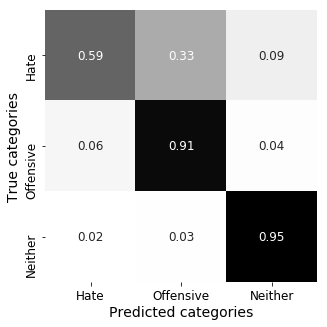

In [102]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test,y_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)

#Uncomment line below if you want to save the output
#plt.savefig('confusion.pdf')

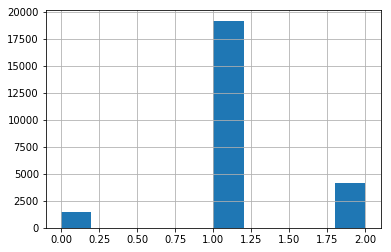

In [103]:
#True distribution
y.hist()

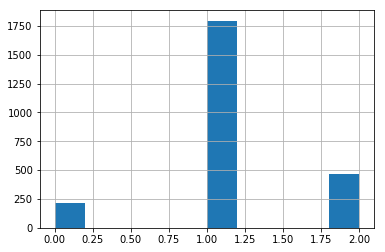

In [104]:
pd.Series(y_preds).hist()

In [105]:
sm = SelectFromModel(LogisticRegression(class_weight='balanced', penalty="l1", C=0.01))

In [107]:
sm.fit(X, y)

SelectFromModel(estimator=LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
        norm_order=1, prefit=False, threshold=None)

In [113]:
feats_best = sm.get_support()
len(feats_best[feats_best==True])

175

In [112]:
[feature_names[i] for i, x in enumerate(feats_best) if x]

['ago',
 'america',
 'american',
 'anoth',
 'ass',
 'ass cracker',
 'ass hoe',
 'ass nigga',
 'bad',
 'beaner',
 'big',
 'bird',
 'bitch',
 'black',
 'border',
 'born',
 'bout',
 'browni',
 'busi',
 'campu',
 'charli',
 'chink',
 'color',
 'color folk',
 'coon',
 'countri',
 'cracker',
 'crazi',
 'crippl',
 'cunt',
 'cuz',
 'da',
 'damn',
 'darki',
 'dick',
 'die',
 'doe',
 'dyke',
 'fag',
 'faggot',
 'fat',
 'femal',
 'feminist',
 'filth',
 'first',
 'folk',
 'fucc nicca',
 'fuck',
 'fuckin',
 'game',
 'gay',
 'girl',
 'gon',
 'good',
 'gook',
 'got nigga',
 'gt gt',
 'hate',
 'hate hoe',
 'hi',
 'hire',
 'ho',
 'hoe',
 'hood',
 'human',
 'israel',
 'jap',
 'jew',
 'jihadi',
 'kill',
 'lame',
 'latina',
 'let',
 'like',
 'lol',
 'look like',
 'love',
 'may',
 'mexican',
 'mock',
 'money',
 'monkey',
 'muslim',
 'muzzi',
 'negro',
 'nicca',
 'nig',
 'nigga',
 'nigga bitch',
 'niggah',
 'niggaz',
 'nigger',
 'nigguh',
 'niglet',
 'oreo',
 'peopl',
 'play',
 'pussi',
 'queer',
 'race',
 